In [1]:
# from google.colab import drive
# drive.mount('/content/drive/', force_remount=True)

In [2]:
# import sys
# sys.path.append('/content/drive/MyDrive/DIPLOMA')

# Этап подготовки данных к моделированию.
**Цель проекта:**
создание рекомендательной системы товаров для ритейл компании.

**Задачи первого этапа**:
1) Подгрузка данных
2) Очистка
3) Разведывательный анализ с визуализацией 
4) Генерация факторов

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px                                # интерактивная визуализации данных
import plotly.graph_objects as go                          # для создания многоуровневых графиков                   
from plotly.subplots import make_subplots                  

import dask.dataframe as dd                                # библиотека для работы с большими данными

from optimize_memory_usage import optimize_memory_usage    # функция оптимизации использования памяти
from time_features import generate_time_features           # функция генерации временных признаков из даты

# отображение графиков в режиме оффлайн
from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)
import plotly.io as pio
pio.renderers.default = "notebook_connected"
# pio.renderers.default = "colab"

import holidays                                            # пакет с праздничными днями
import warnings
warnings.filterwarnings('ignore')

## 1.Этап знакомства с данными.
Прежде чем мы будем загружать данные, желательно посмотреть, насколько они большие.

In [4]:
# path = '/content/drive/MyDrive/DIPLOMA'
files = ["data/category_tree.csv", "data/events.csv", 
         "data/item_properties_part1.csv", "data/item_properties_part2.csv"] # список файловых данных

for file in files:
    # file_path = f"{path}/{file}"  # Формируем полный путь к файлу
    # Посчитаем количество строк в файле
    with open(file, 'r') as f:
        rows = sum(1 for line in f)
        print(f"Всего строк в файле {file}: {rows:,}")

Всего строк в файле data/category_tree.csv: 1,670
Всего строк в файле data/events.csv: 2,756,102
Всего строк в файле data/item_properties_part1.csv: 11,000,000
Всего строк в файле data/item_properties_part2.csv: 9,275,904


### 1.1 Events
Файл *events* достаточно большой, но гораздо уступает последним двум, начнем с него.

In [5]:
with open('data/events.csv', 'r') as f:    # with open(path+'/events.csv', 'r') as f:
    events = pd.read_csv(f)
events.head()

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN


In [6]:
# взглянем на типы данных и занимаемый размер памяти
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2756101 entries, 0 to 2756100
Data columns (total 5 columns):
 #   Column         Dtype  
---  ------         -----  
 0   timestamp      int64  
 1   visitorid      int64  
 2   event          object 
 3   itemid         int64  
 4   transactionid  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 105.1+ MB


Мы видим достаточно большой используемый размер памяти, поэтому будем сразу изменять типы данных, чтобы при обработке потреблялось меньше ресурсов.\
Применим функцию для оптимизации использования памяти.

In [7]:
events = optimize_memory_usage(events)

Начальный размер памяти: 244.92 MB
Конечный размер памяти: 49.94 MB
Экономия памяти: 194.98 MB


Преобразовываем признак *timestamp*.\
Даты представлены в формате Unix timestamp (в миллисекундах). Преобразуем их в формат datetime, указав параметром unit='ms'.

In [8]:
events['timestamp'] = pd.to_datetime(events['timestamp'], unit='ms')
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2756101 entries, 0 to 2756100
Data columns (total 5 columns):
 #   Column         Dtype         
---  ------         -----         
 0   timestamp      datetime64[ns]
 1   visitorid      uint32        
 2   event          category      
 3   itemid         uint32        
 4   transactionid  float16       
dtypes: category(1), datetime64[ns](1), float16(1), uint32(2)
memory usage: 49.9 MB


### 1.2 Properties
Перейдем к загрузке данных о товарах и их свойствах.\
Файлы *item_properties_part1.csv*, *item_properties_part2.csv* имеют большое количество объектов, выведем первые несколько строк, посмотрим на типы и при загрузке поменяем тип данных, а потом оптимизируем итоговый датасет.

In [9]:
with open('data/item_properties_part1.csv', 'r') as f:   # with open(path+'/item_properties_part1.csv', 'r') as f:
    sample = pd.read_csv(f, nrows=1000)
sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   timestamp  1000 non-null   int64 
 1   itemid     1000 non-null   int64 
 2   property   1000 non-null   object
 3   value      1000 non-null   object
dtypes: int64(2), object(2)
memory usage: 31.4+ KB


In [10]:
# Определяем типы данных для оптимизации памяти
dtypes = {
    "timestamp": "uint64",
    "itemid": "uint32"
}
# Загружаем файлы с указанием типов
with open("data/item_properties_part1.csv", 'r') as f:    # with open(path+"/item_properties_part1.csv", 'r') as f:
    properties1 = pd.read_csv(f, dtype=dtypes)

with open("data/item_properties_part2.csv", 'r') as f:    # with open(path+"/item_properties_part2.csv", 'r') as f:
    properties2 = pd.read_csv(f, dtype=dtypes)

# Объединяем данные
properties = pd.concat([properties1, properties2], axis=0, ignore_index=True)
# Применяем функцию оптимизации использования памяти
properties = optimize_memory_usage(properties)

properties.info()

Начальный размер памяти: 2848.15 MB
Конечный размер памяти: 593.43 MB
Экономия памяти: 2254.72 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20275902 entries, 0 to 20275901
Data columns (total 4 columns):
 #   Column     Dtype   
---  ------     -----   
 0   timestamp  uint64  
 1   itemid     uint32  
 2   property   category
 3   value      category
dtypes: category(2), uint32(1), uint64(1)
memory usage: 427.6 MB


Переводим, как и ранее, признак *timestamp* в нужный формат datetime.

In [11]:
properties["timestamp"] = pd.to_datetime(properties["timestamp"], unit="ms")
properties.head()

,timestamp,itemid,property,value
0,2015-06-28 03:00:00,460429,categoryid,1338
1,2015-09-06 03:00:00,206783,888,1116713 960601 n277.200
2,2015-08-09 03:00:00,395014,400,n552.000 639502 n720.000 424566
3,2015-05-10 03:00:00,59481,790,n15360.000
4,2015-05-17 03:00:00,156781,917,828513


### 1.3 Category_tree

In [12]:
with open("data/category_tree.csv", 'r') as f:      # with open(path+"/category_tree.csv", 'r') as f:
    tree = pd.read_csv(f)
tree.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1669 entries, 0 to 1668
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   categoryid  1669 non-null   int64  
 1   parentid    1644 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 26.2 KB


#### Описание данных:
1) events — датасет событий:
* timestamp — время события,
* visitorid — идентификатор пользователя,
* event — тип события,
* itemid — идентификатор объекта,
* transactionid — идентификатор транзакции, если она проходила.

2) tree — датасет с деревом категорий:
* category_id — идентификатор категорий,
* parent_id — идентификатор родительской категории.

3) properties — датасет со свойствами товаров:
* timestamp — момент записи значения свойства,
* itemid — идентификатор объекта,
* property — свойства-категории (зашифрованы в числовые значения),
* value — значение также зашифровано (перечисление каких-то id).

## 2. Очистка от пропусков и дубликатов
### 2.1 Датасет events

In [13]:
print('Пропуски в данных о событиях: ', events.isnull().sum(), sep='\n')

Пропуски в данных о событиях: 
timestamp              0
visitorid              0
event                  0
itemid                 0
transactionid    2733644
dtype: int64


In [14]:
# как вообще выглядят значения признака transactionid
print(events['transactionid'].unique()[:20])

[   nan  4000. 11120.  5444. 13552.  7244.  8800.  5216. 11712.  2416.
 15912. 14928. 11616. 11952.  3052. 11416.  1343. 11136.  1798. 16608.]


Логично, что огромное количество пропусков в признаке идентификатора транзакции, мы видили, что тип события-транзакция встречается очень мало по сравнению с большинством событий типа view (просмотры). То есть если событие *event* типа транзакция, то в признаке *transactionid* имеется id транзакции, в остальных значениях - пропуск NaN.

Преобразуем признак в *transaction*: 1 - если состоялось событие ⇒ транзакция, 0 - иное событие.

In [15]:
# Переименование столбца 'transactionid' в 'transaction'
events.rename(columns={'transactionid': 'transaction'}, inplace=True)
# преобразование в бинарный признак
events['transaction'] = events['transaction'].apply(lambda x: 0 if pd.isna(x) else 1).astype('uint8')
events['transaction'].value_counts()

transaction
0    2733644
1      22457
Name: count, dtype: int64

Удалим дубликаты, если они имеются.

In [16]:
duplicates = events.duplicated()
# Подсчет количества дубликатов
num_duplicates = duplicates.sum()
print(f"Количество дубликатов в наборе о событиях: {num_duplicates}")
# удалим дубликаты
events.drop_duplicates(inplace=True)

Количество дубликатов в наборе о событиях: 460


Отсортируем данные о событиях по датам и посмотрим, за какой период мы имеет данные.

In [17]:
events = events.sort_values(by='timestamp').reset_index(drop=True)
print(f"Период собранных данных для набора событий: с {events['timestamp'].min().date()} по {events['timestamp'].max().date()}")

Период собранных данных для набора событий: с 2015-05-03 по 2015-09-18


C 3 мая по 18 сентября 2015 года - данные за 4,5 месяца.

### 2.2 Датасет tree

In [18]:
print('Пропуски в дереве категорий: ', tree.isnull().sum(), sep='\n')

Пропуски в дереве категорий: 
categoryid     0
parentid      25
dtype: int64


**Воссоздание дерева категорий**:
1) Создаем словарь связей (categoryid → parentid).
2) Рекурсивно вычисляем глубину каждой категории, начиная с корневых узлов.

In [19]:
tree['parentid'] = tree['parentid'].fillna(-1).astype(int)  # Заменяем NaN на -1

# Создаем словарь parent-child
category_dict = dict(zip(tree['categoryid'], tree['parentid']))

# Функция для вычисления глубины узла
def get_depth(category_id, depth_cache={}):
    if category_id in depth_cache:
        return depth_cache[category_id]
    if category_id == -1:
        return 0
    parent_id = category_dict.get(category_id, -1)
    depth_cache[category_id] = 1 + get_depth(parent_id, depth_cache)
    return depth_cache[category_id]

# Вычисляем глубину для всех категорий
tree['depth'] = tree['categoryid'].map(lambda x: get_depth(x))

# Выводим дерево с глубиной вложенности
print(tree.sort_values('depth').head())

      categoryid  parentid  depth
1624         395        -1      1
1616        1482        -1      1
1476        1452        -1      1
1142         378        -1      1
1329        1057        -1      1


Теперь мы можем проанализировать структуры дерева: понять, какие категории являются основными, а какие вложенными.

Если в датасете properties признак property соответствует categoryid, то можно связать свойства с уровнями вложенности и анализировать закономерности. Тем самым мы можем анализировать путь пользователя по категориям и улучшать персонализацию для рекомендательных систем.

### 2.3 Датасет properties

In [20]:
# проверка пропусков
properties.isnull().sum()

timestamp    0
itemid       0
property     0
value        0
dtype: int64

In [21]:
# проверка дубликатов
duplicates = properties.duplicated()
# подсчет количества дубликатов
num_duplicates = duplicates.sum()
print(f"Количество дубликатов в датасете о товарах: {num_duplicates}")

Количество дубликатов в датасете о товарах: 0


Данный датасет содержит интересный фактор - property: зафишрованное свойство товара. Давайте посмотрим его.

In [22]:
# сколько уникальных значений у признака property
properties.property.nunique()

1104

In [23]:
# Фильтруем значения в признаке property, которые содержат не только цифры
words_property = set(properties['property'][~properties['property'].str.isdigit()])
# Выводим результат
print(f"Уникальные значения, состоящие не только из цифр: {words_property}")

Уникальные значения, состоящие не только из цифр: {'categoryid', 'available'}


Наблюдаем всего два буквенных свойства property, можем перевести их в числовые и преобразовать тип данного признака в числовой.

In [24]:
# Преобразуем все значения в столбце 'property', которые являются числами, в список чисел
# Это исключит текстовые значения
numeric_values = pd.to_numeric(properties['property'], errors='coerce').dropna().astype(int).unique()

# Находим минимальное и максимальное число в текущем списке числовых значений
min_value = numeric_values.min()
max_value = numeric_values.max()

# Создаем список чисел, которые не присутствуют в текущем наборе
all_numbers = set(range(min_value, max_value + 1))
missing_numbers = list(all_numbers - set(numeric_values))
missing_numbers

[946, 474, 226]

Итак, для значения *categoryid* мы присвоем число 226, для значения *available* - 474.

In [25]:
replace_values = {'categoryid': missing_numbers[2], 'available': missing_numbers[1]}
# Заменяем текстовые значения на выбранные числа
properties['property'] = properties['property'].replace(replace_values)
properties.property.nunique()

1104

In [26]:
# не забываем оптимизировать
properties['property'] = properties['property'].astype('uint16') # [0, 65535]
properties.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20275902 entries, 0 to 20275901
Data columns (total 4 columns):
 #   Column     Dtype         
---  ------     -----         
 0   timestamp  datetime64[ns]
 1   itemid     uint32        
 2   property   uint16        
 3   value      category      
dtypes: category(1), datetime64[ns](1), uint16(1), uint32(1)
memory usage: 427.6 MB


Отобразим топ-20 значений в признаке *property* на столбчатой диаграмме.

In [27]:
top_properties = properties.property.astype('string').value_counts().reset_index()[:20]
top_properties.columns = ['property', 'count']
fig = px.bar(top_properties,
             x='property',
             y='count',
             color_discrete_sequence=px.colors.qualitative.Set3)
fig.update_layout(
    title={'text': "Топ-20 property", 'x':0.5, 'xanchor':'center', 'yanchor':'top'},    # название графика и расположение
    width=800, height=400,                                                              # размеры графика
    autosize=False, margin=dict(t=30, b=30, l=30, r=10),                                # отступы от плоскости
    template='plotly'                                                                   # стиль
)
fig.write_image("images/Топ-20 популярных категорий товаров.png", engine='kaleido')
iplot(fig)

Наши буквенные свойства товаров (теперь 474 и 226) в лидерах по частоте.

Также изучим значения признака value и произведем очистку-преобразование в случае необходимости.

In [28]:
properties['value'].unique()[:20].tolist()

['1338',
 '1116713 960601 n277.200',
 'n552.000 639502 n720.000 424566',
 'n15360.000',
 '828513',
 '0',
 '1121373',
 '319724',
 '1330310',
 '1141052 n48.000',
 '1038400 45956 n504.000',
 '1283144 353870',
 '1026952 1162729',
 'n21000.000',
 'n5400.000',
 '1292080',
 'n36.000 1186610 119932 717520 903287 98606 632686 1117759 504389 227411 768453 414047 1008741 561431 508431 621351 976840 260167 934278 388767 42948',
 '857891 593337',
 'n480.000 639502 189174',
 '519769']

Давайте начнем с удаления всех 'n' из значений.

In [29]:
# Получаем оригинальные категории
categories = properties['value'].cat.categories

# Создаем словарь замен
replace_dict = {cat: cat.replace('n', '') for cat in categories}

# Применяем замену
properties['value'] = properties['value'].map(replace_dict).astype('category')

# Проверяем результат
properties['value'].unique()[:20].tolist()

['1338',
 '1116713 960601 277.200',
 '552.000 639502 720.000 424566',
 '15360.000',
 '828513',
 '0',
 '1121373',
 '319724',
 '1330310',
 '1141052 48.000',
 '1038400 45956 504.000',
 '1283144 353870',
 '1026952 1162729',
 '21000.000',
 '5400.000',
 '1292080',
 '36.000 1186610 119932 717520 903287 98606 632686 1117759 504389 227411 768453 414047 1008741 561431 508431 621351 976840 260167 934278 388767 42948',
 '857891 593337',
 '480.000 639502 189174',
 '519769']

In [30]:
# Проверяем, есть ли в столбце `value` текстовые значения
mask = properties['value'].str.contains(r'[a-zA-Z]', regex=True, na=False)
# оставляем уникальные значения
words_value = set(properties.loc[mask, 'value'])

# Выводим результат
print(f"Уникальные значения, содержащие слова: {words_value}")

Уникальные значения, содержащие слова: {'119194 1047879 1065616 688107 891317 Ifiity 1047879 1065616 688107 891317 Ifiity 1081419 1128577 901561 156.000 188678 1174704 1215254 615344 1260136 42114 653611 156682 145396 1101397 374631 1149392 193129 1235128 581854 416887 191835 1284004', '1328368 982487 1115724 12092 Ifiity', '1081259 Ifiity 88645', '1096229 982487 355347 54657 6960.000 946544 355347 Ifiity 54657 6960.000 985136 639502 1096229 982487 169962 951278 150169 642930 402228 857685 1128577 141646 384135 167931 30603 1320974 495242 1158829 21098 227411 5041 1135856 30603 325677 1128577 467612', 'Ifiity', '1328368 982487 1115724 42654 Ifiity', '956975 1065616 688107 358393 Ifiity', '1247872 Ifiity', '956975 1065616 688107 358393 Ifiity 1271814', '1247872 Ifiity 1318567', '12092 Ifiity', '1096229 1047879 1065616 688107 1081259 Ifiity', '891317 Ifiity', '1096229 982487 355347 724380 9360.000 355347 Ifiity 724380 206585 639502 1096229 982487 169962 951278 150169 642930 402228 857685

Итак, мы обнаружили еще одно непонятное значение, не являющееся числовым, давайте удалим его.

In [31]:
# Удаляем "Ifiity" из значений столбца `value`
properties['value'] = properties['value'].str.replace(r'\bIfiity\b', '', regex=True).str.strip()
properties['value'] = properties['value'].astype('category')

Мы пока не знаем, что содержит данный признак, возможно это идентификаторы пользователей, которые купили соотвествующий товар, или что-то иное.

Осталось произвести сортировку по датам и сделаем это с помощью dataframe dask, чтобы CPU справился с таким объемом.

In [32]:
# Преобразуем pandas DataFrame в Dask DataFrame с 10 частями
ddf = dd.from_pandas(properties, npartitions=10)

# Сортируем данные по столбцу 'timestamp' в Dask, затем загружаем обратно в pandas
properties = ddf.sort_values('timestamp').compute()

# Проверяем результат
print(f"Период собранных данных о товаров: с {properties['timestamp'].dt.date.min()} по {properties['timestamp'].dt.date.max()}")

Период собранных данных о товаров: с 2015-05-10 по 2015-09-13


Период в датасете товаров немного отличается от дат набора событий, данные начинаются не с 3 мая, а с 10, заканчиваются не 18 сентября, а на 5 дней раньше.

## 3. Exploratory Data Analysis
### 3.1 Изучение типов событий в данных events.

In [33]:
# Подсчитываем количество событий
event_type = events['event'].value_counts().reset_index()
event_type.columns = ['event', 'count']  # переименовываем столбцы

# Создаем круговую диаграмму с отображением типа события и его количества в процентном соотношении
fig = px.pie(event_type,
             values='count',
             names='event',
             hover_name='event')

# Настройка отображения текста (название события и процентное соотношение)
fig.update_traces(textinfo='percent+label')
fig.update_layout(
    title={'text': "Соотношение типов событий в данных", 'x': 1, 'xanchor':'right', 'yanchor':'top'},
    width=600, height=400,                                                         # размеры графика
    autosize=False, margin=dict(t=30, b=30, l=30, r=10),                           # отступы от плоскости
    template='plotly'                                                              # стиль
)
fig.write_image("images/Соотношение типов событий.png", engine="kaleido")
iplot(fig)

### 3.2 Соотношение количества товаров *itemid* относительно типа события.

In [34]:
# группируем количество itemid по событиям
item_events = events.groupby('event')['itemid'].count().reset_index()
item_events.columns = ['type_event', 'item_count']
# Столбчатая диаграмма
fig = px.bar(item_events,
             y='type_event',
             x='item_count',
             orientation='h', # расположение
             color_discrete_sequence=['lightgreen'])
fig.update_layout(
    title={'text': "Распределение количества товаров по типам события", 'font': {'size': 18},
           'x':0.5, 'xanchor':'center', 'yanchor':'top'},
    width=1000, height=300,                                                             # размеры графика
    autosize=True, margin=dict(t=40, b=30, l=30, r=10),                                # отступы от плоскости
    template='plotly',                                                                  # стиль
    xaxis_title='количество товаров',
    yaxis_title='типы события'
)
iplot(fig)

### 3.3 Извлечение различных факторов времени из даты в данных events и их анализ.
Временные признаки обычно являются кладезем полезной информации при выявлении закономерностей и моделировании, поэтому сгенерируем новые факторы из признака *timestamp* с помощью функции generate_time_features.

In [35]:
# применим функцию для датасета events
generate_time_features(events)
events.head()

,timestamp,visitorid,event,itemid,transaction,dayofmonth,month,dayofweek,dayofweek_str,week_of_year,is_weekend,is_holiday,hour,part_of_day,time_diff_ms
0,2015-05-03 03:00:04.384,693516,addtocart,297662,0,3,5,6,Sunday,18,True,False,3,Night,NaN
1,2015-05-03 03:00:11.289,829044,view,60987,0,3,5,6,Sunday,18,True,False,3,Night,6905.0
2,2015-05-03 03:00:13.048,652699,view,252860,0,3,5,6,Sunday,18,True,False,3,Night,1759.0
3,2015-05-03 03:00:24.154,1125936,view,33661,0,3,5,6,Sunday,18,True,False,3,Night,11106.0
4,2015-05-03 03:00:26.228,693516,view,297662,0,3,5,6,Sunday,18,True,False,3,Night,2074.0


In [36]:
# оптимизируем потребление CPU
events = optimize_memory_usage(events)

Начальный размер памяти: 464.52 MB
Конечный размер памяти: 91.98 MB
Экономия памяти: 372.54 MB


**Распределение событий по дням недели**

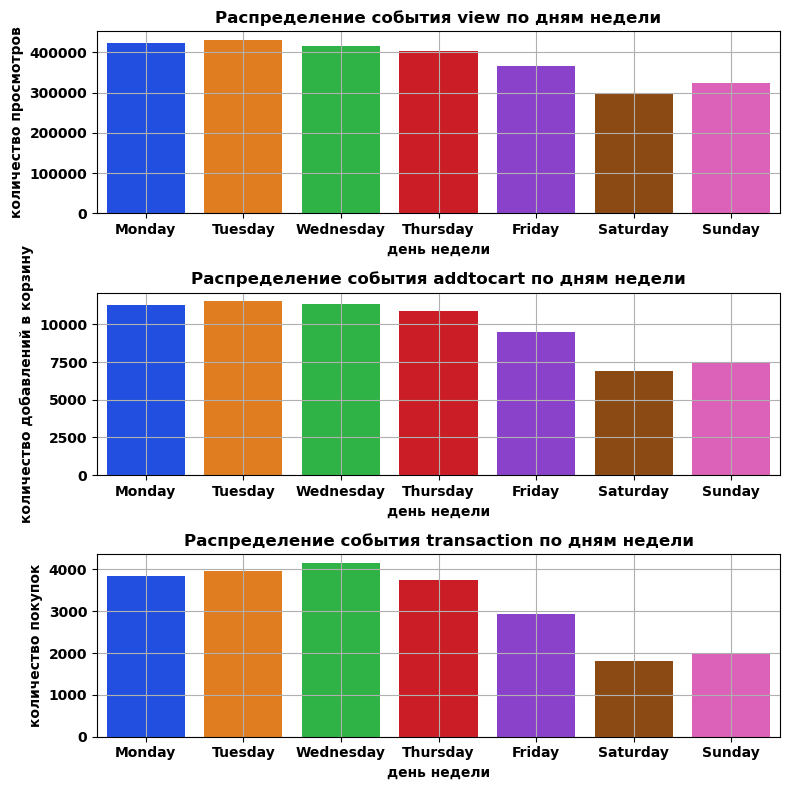

In [37]:
# группируем по дням недели отдельно каждый тип события
dayofweek_view = events[events['event']=='view'].groupby('dayofweek_str')['event'].size().reset_index()
dayofweek_view.columns = ['day_of_week', 'count_view']
dayofweek_addtocart = events[events['event']=='addtocart'].groupby('dayofweek_str')['event'].size().reset_index()
dayofweek_addtocart.columns = ['day_of_week', 'count_addtocart']
dayofweek_transaction = events[events['event']=='transaction'].groupby('dayofweek_str')['event'].size().reset_index()
dayofweek_transaction.columns = ['day_of_week', 'count_transaction']

# Определяем порядок дней недели, начиная с понедельника
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Преобразуем столбец day_of_week в категориальный тип с заданным порядком
dayofweek_view['day_of_week'] = pd.Categorical(dayofweek_view['day_of_week'], categories=days_order, ordered=True)
dayofweek_addtocart['day_of_week'] = pd.Categorical(dayofweek_addtocart['day_of_week'], categories=days_order, ordered=True)
dayofweek_transaction['day_of_week'] = pd.Categorical(dayofweek_transaction['day_of_week'], categories=days_order, ordered=True)

fig, ax = plt.subplots(3,1, figsize=(8, 8))
# распределение просмотров по дням недели
sns.barplot(data=dayofweek_view, x='day_of_week', y='count_view', palette='bright', ax=ax[0])
ax[0].set_title('Распределение события view по дням недели')
ax[0].set_xlabel('день недели')
ax[0].set_ylabel('количество просмотров')
ax[0].grid(True)
# распределение добавления в корзину по дням недели
sns.barplot(data=dayofweek_addtocart, x='day_of_week', y='count_addtocart', palette='bright', ax=ax[1])
ax[1].set_title('Распределение события addtocart по дням недели')
ax[1].set_xlabel('день недели')
ax[1].set_ylabel('количество добавлений в корзину')
ax[1].grid(True)
# распределение покупок по дням недели
sns.barplot(data=dayofweek_transaction, x='day_of_week', y='count_transaction', palette='bright', ax=ax[2])
ax[2].set_title('Распределение события transaction по дням недели')  # название графика
ax[2].set_xlabel('день недели')
ax[2].set_ylabel('количество покупок')
ax[2].grid(True)
# выравнивание графиков
plt.tight_layout()
plt.show()

Все типы действий отражают похожую интенсивность по дням недели, единственным малым отличием является событие покупки, где лидирует среда по сравнению с понедельником и вторником для просмотров и добавлений в корзину. Самая низкая активность в выходные дни.

Таким же образом визуализируем **распределение событий по часам суток**.

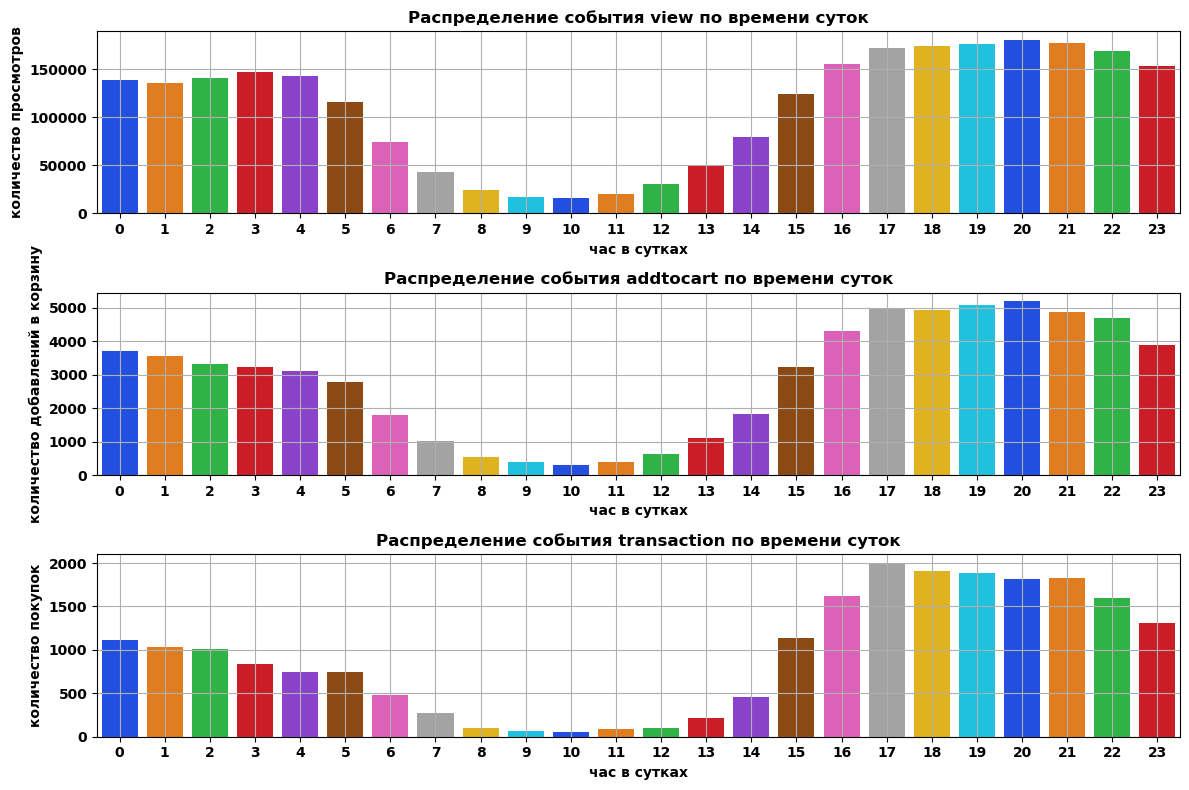

In [38]:
# группируем события по часам в сутках
hour_view = events[events['event']=='view'].groupby('hour')['event'].size().reset_index()
hour_view.columns = ['hour_of_day', 'count_view']
hour_addtocart = events[events['event']=='addtocart'].groupby('hour')['event'].size().reset_index()
hour_addtocart.columns = ['hour_of_day', 'count_addtocart']
hour_transaction = events[events['event']=='transaction'].groupby('hour')['event'].size().reset_index()
hour_transaction.columns = ['hour_of_day', 'count_transaction']

# Определяем часовой порядок
hours_order = list(range(24))

# Преобразуем столбец day_of_week в категориальный тип с заданным порядком
hour_view['hour_of_day'] = pd.Categorical(hour_view['hour_of_day'], categories=hours_order, ordered=True)
hour_addtocart['hour_of_day'] = pd.Categorical(hour_addtocart['hour_of_day'], categories=hours_order, ordered=True)
hour_transaction['hour_of_day'] = pd.Categorical(hour_transaction['hour_of_day'], categories=hours_order, ordered=True)

fig, ax = plt.subplots(3,1, figsize=(12, 8))
# распределение просмотров в течение суток
sns.barplot(data=hour_view, x='hour_of_day', y='count_view', palette='bright', ci=False, ax=ax[0])
ax[0].set_title('Распределение события view по времени суток')
ax[0].set_xlabel('час в сутках')
ax[0].set_ylabel('количество просмотров')
ax[0].grid(True)
# распределение добавления в корзину в течение суток
sns.barplot(data=hour_addtocart, x='hour_of_day', y='count_addtocart', palette='bright', ci=False, ax=ax[1])
ax[1].set_title('Распределение события addtocart по времени суток')
ax[1].set_xlabel('час в сутках')
ax[1].set_ylabel('количество добавлений в корзину')
ax[1].grid(True)
# распределение покупок в течение суток
sns.barplot(data=hour_transaction, x='hour_of_day', y='count_transaction', palette='bright', ci=False, ax=ax[2])
ax[2].set_title('Распределение события transaction по времени суток')
ax[2].set_xlabel('час в сутках')
ax[2].set_ylabel('количество покупок')
ax[2].grid(True)
# выравнивание графиков
plt.tight_layout()
plt.show()

Как видим, здесь похожая картина, распределение между типами действий практически одинаковы, пик активности пользователей приходится с 4  до 11 вечера.

На какой из месяцев нашего периода пришелся пик активности в действиях пользователей?

In [39]:
month_event = events.groupby(['month', 'event']).size().reset_index(name='count_event')

fig = px.bar(month_event,
             x='month',
             y='count_event',
             color='event',  # разделение по типам событий через цвета
             barmode='group')
fig.update_layout(
    title={'text': "Интенсивность событий по месяцам", 'font': {'size': 18},
           'x':0.5, 'xanchor':'center', 'yanchor':'top'},
    width=1000, height=500,
    autosize=True, margin=dict(t=40, b=30, l=30, r=10),
    template='plotly',
    xaxis_title='номер месяц',
    yaxis_title='число событий'
)
iplot(fig)

### 3.4 Визуальный анализ самых активных пользователей по покупкам и самых популярных товаров.
Для начала посмотрим на топ-20 пользователей *visitorid* данного периода.

In [40]:
# группируем пользователей по количеству транзакций
top_visitors = events[events['transaction']==1]['visitorid'].value_counts().nlargest(20).reset_index()
top_visitors['visitorid'] = top_visitors['visitorid'].astype(str)

fig = px.bar(top_visitors,
             y='count',
             x='visitorid',
             color_discrete_sequence=px.colors.qualitative.Set3) # задаем цвет диаграммы

fig.update_layout(
    title={'text': "Топ-20 пользователей по покупкам", 'font': {'size': 18},
           'x':0.5, 'xanchor':'center', 'yanchor':'top'},
    width=800, height=400,
    autosize=True, margin=dict(t=40, b=30, l=30, r=10),
    template='plotly',
    xaxis_title='Пользователи-лидеры по покупкам',
    yaxis_title='Количество транзакций'
)
fig.write_image("images/Топ-20 пользователей по покупкам.png", engine='kaleido')
iplot(fig)

Невероятно, за 4,5 месяца более 500 транзакций, 2-3 места: 349 и 286 транзакций.

Тогда вопрос, какие товары были самыми популярными за данный период. Таким же образом, визуализируем топ-20 товаров *itemid*.

In [41]:
# группируем товары по количеству транзакций
top_items = events[events['transaction']==1]['itemid'].value_counts().nlargest(20).reset_index()
top_items['itemid'] = top_items['itemid'].astype('string')

fig = px.bar(top_items,
             y='count',
             x='itemid',
             color_discrete_sequence=px.colors.qualitative.Set3)
fig.update_layout(
    title={'text': "Топ-20 купленных товаров", 'font': {'size': 18},
           'x':0.5, 'xanchor':'center', 'yanchor':'top'},
    width=800, height=400,
    autosize=True, margin=dict(t=40, b=30, l=30, r=10),
    template='plotly',
    xaxis_title='Товары-лидеры продаж',
    yaxis_title='Количество покупок'
)
fig.write_image("images/Топ-20 самых популярных товаров среду купленных.png", engine='kaleido')
iplot(fig)

Осталось определить: наши самые активные пользователи по покупкам выбирали самые популярные товары или нет? Давайте проверим 30 лидеров по покупкам и их топовые из купленных товаров.

In [42]:
# Фильтруем события по транзакциям
filtered_events = events[events['transaction'] == 1].copy()

# Определяем топ-30 пользователей по количеству транзакций
top30_visitors = filtered_events['visitorid'].value_counts().nlargest(30).index

# Фильтруем данные по топ-30 пользователей
filtered_data = filtered_events[filtered_events['visitorid'].isin(top30_visitors)]

# Определяем топ-30 самых популярных товаров среди этих пользователей
top30_items = filtered_data['itemid'].value_counts().nlargest(30).index

total_top_items = events[events['transaction']==1]['itemid'].value_counts().nlargest(30).index

matches = set(total_top_items.tolist()) & set(top30_items.tolist())
print('Товары из топ-30 самых популярных и которые покупали топ-30 пользователей по покупкам:')
print(matches)
print('Число таких товаров: ', len(matches))

Товары из топ-30 самых популярных и которые покупали топ-30 пользователей по покупкам:
{420960, 334401, 320130, 546, 37029, 369158, 248455, 445351, 17478, 213834, 46156, 190000, 268883, 9877, 119736, 318333, 48030}
Число таких товаров:  17


Мы выявили важную закономерность:\
лидеры среди пользователей, совершившых конверсию - покупку, купили 17 из самых популярных на тот период 30 товаров.\
Это говорит о том, что текущая популярность товара влияет на его конверсию.

Также мы должны проверить влияние времени на конверсию популярных товаров, так как нам поручено создать рекомендательную систему, мы должны проверить факт рентабельности рекомендации самых популярных товаров в течение длительного периода.

Мы рассчитаем процент продаж топ-3 товаров от общих продаж за период до 1 июля 2015 года включительно и проверим конверсию этих же товаров после 1 июля.

In [43]:
# Фильтруем транзакции до 1 июля 2015 года включительно
before_july = events[(events['transaction'] == 1) & (events['timestamp'] <= '2015-07-01')]

# Находим топ-3 товаров по числу транзакций
top3_items_before = before_july['itemid'].value_counts().nlargest(3)

# Общее количество продаж до 1 июля
total_sales_before = before_july.shape[0]

# Выведем статистику
print("Топ-3 товаров по транзакциям до 1 июля 2015:")
print(top3_items_before)
# Рассчитываем процент
top3_percent_before = (top3_items_before.sum() / total_sales_before) * 100
print(f"Процент продаж топ-3 товаров в общем количестве продаж до 1 июля: {top3_percent_before:.3f} %", )

Топ-3 товаров по транзакциям до 1 июля 2015:
itemid
119736    36
369447    31
7943      30
Name: count, dtype: int64
Процент продаж топ-3 товаров в общем количестве продаж до 1 июля: 1.005 %


In [44]:
# Фильтруем транзакции после 1 июля 2015
after_july = events[(events['transaction'] == 1) & (events['timestamp'] > '2015-07-01')]

# Считаем, сколько раз товары из топ-3 (до 1 июля) покупались после 1 июля
items_after = after_july[after_july['itemid'].isin(top3_items_before.index)]['itemid'].value_counts()

# Выведем статистику
print(items_after)
# Общее количество продаж после 1 июля
total_sales_after = after_july.shape[0]
# Рассчитываем процент
top3_percent_after = (items_after.sum() / total_sales_after) * 100
print(f"Процент продаж товаров из топ-3 после 1 июля {top3_percent_after:.3f} % от всех продаж после 1 июля.")

itemid
119736    61
7943      16
Name: count, dtype: int64
Процент продаж товаров из топ-3 после 1 июля 0.601 % от всех продаж после 1 июля.


**Выводы**:
1) Мы видим, что один товар из топ-3 уже не актуален после 1 июля, то есть пользователи перестали его покупать, в связи с чем, продажи именно топовых ранее товаров упали.
2) Если мы будем на протяжении длительного периода продолжать рекомендовать одни и те же популярные товары, то продажи будут сокращаться, их актуальность для пользователей исчезает со временем.

## 4. Генерация факторов
### 4.1 Генерация факторов для товаров *itemid*
1) Частота просмотров товара;
2) Частота добавления товара в корзину;
3) Частота покупки товара;
4) Конверсия (покупки/просмотры);
5) Количество уникальных свойств у товара.

In [45]:
# 1. 2. 3. Группируем по itemid и считаем метрики
item_factors = events.groupby('itemid').agg(
    view_count=('event', lambda x: (x == 'view').count()),             # количество просмотров товра
    addtocart_count=('event', lambda x: (x == 'addtocart').count()),   # количество добавлений товара в корзину
    purchase_count=('transaction', 'sum')                              # сумма транзакций - покупок товра
).reset_index()

# 4. Вычисляем конверсию
item_factors['conversion'] = item_factors['purchase_count'] / item_factors['view_count']
item_factors['conversion'] = item_factors['conversion'].fillna(0)  # заполняем пропуски нулем

# Объединяем с исходным events
events = events.merge(item_factors, on='itemid', how='left')

# Проверяем результат
print(events[['itemid', 'view_count', 'addtocart_count', 'purchase_count', 'conversion']].head())

   itemid  view_count  addtocart_count  purchase_count  conversion
0  297662          63               63               0         0.0
1   60987          79               79               0         0.0
2  252860         248              248               0         0.0
3   33661          63               63               0         0.0
4  297662          63               63               0         0.0


Давайте взглянем, товары-лидеры по просмотрам являются ли лидерами по покупкам?

In [46]:
# Топ-20 товаров по просмотрам и покупкам
top_view_items = events.groupby('itemid')['view_count'].sum().nlargest(20).reset_index()
top_purchase_items = events.groupby('itemid')['purchase_count'].sum().nlargest(20).reset_index()

# Преобразуем itemid в строковый тип
top_view_items['itemid'] = top_view_items['itemid'].astype(str)
top_purchase_items['itemid'] = top_purchase_items['itemid'].astype(str)

# Создаем фигуру с двумя подграфиками
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.1,
                    subplot_titles=('Топ-20 товаров по просмотрам', 'Топ-20 товаров по покупкам'))

# Добавляем данные для графика по просмотрам
fig.add_trace(go.Bar(x=top_view_items['itemid'], y=top_view_items['view_count'], name='Топ-20 товаров по просмотрам'),
              row=1, col=1)

# Добавляем данные для графика по покупкам
fig.add_trace(go.Bar(x=top_purchase_items['itemid'], y=top_purchase_items['purchase_count'], name='Топ-20 товаров по покупкам'),
              row=2, col=1)

# Обновляем макет
fig.update_layout(
    width=1100, height=600,
    autosize=True, margin=dict(t=40, b=40, l=40, r=10),
    template="plotly",
    showlegend=False
)
fig.write_image("images/Сравнение топовых товаров по просмотрам и покупкам.png", engine='kaleido')
iplot(fig)

Итак, теперь мы знаем, что самые популярные товары по просмотрам не всегда в топе продаж.

In [47]:
# 5. Группируем уникальные свойства по товарам
property_count = properties.groupby('itemid')['property'].nunique().rename('property_count')
# объединяем с исходным properties
properties = properties.merge(property_count, on='itemid', how='left')
properties.head()

,timestamp,itemid,property,value,property_count
0,2015-05-10 03:00:00,317951,790,32880.000,24
1,2015-05-10 03:00:00,422842,480,1133979,35
2,2015-05-10 03:00:00,310185,776,103591,25
3,2015-05-10 03:00:00,110973,112,679677,21
4,2015-05-10 03:00:00,179597,474,0,22


### 4.2 Генерация временных характеристик товаров *itemid*
1) Первое появление товара;
2) Последняя активность товара;
3) Среднее время между просмотрами конкретного itemid;
4) Среднее время между добавлениями в корзину конкретного itemid;
5) Среднее время между покупками конкретного itemid.

In [48]:
# 1. 2. Первое и последнее появление товара
first_seen = events.groupby('itemid')['timestamp'].min().rename("first_seen")
last_seen = events.groupby('itemid')['timestamp'].max().rename("last_seen")

lst_df = []  # список датафреймов
event_types = ['view', 'addtocart', 'transaction']
# 3. 4. 5.
for e in event_types:
    # Фильтруем по событию
    df = events[events['event'] == e].copy()
    # Сортируем по товару и времени события
    df.sort_values(by=['itemid', 'timestamp'], inplace=True)
    # Вычисляем разницу времени между событиями
    df['time_diff'] = df.groupby('itemid')['timestamp'].diff()
    # Вычисляем среднее время между событиями
    avg_time_event = df.groupby('itemid')['time_diff'].mean()

    # Заменяем NaT на 0 перед вычислением секунд, переводим в часы
    avg_time_event = avg_time_event.fillna(pd.Timedelta(seconds=0)).dt.total_seconds() / 3600
    # округляем значения и переименовываем столбец
    avg_time_event = avg_time_event.round(2).rename(f'avg_time_{e}')
    # добавляем в список
    lst_df.append(avg_time_event)

# Объединяем все факторы в один датафрейм
time_item_factors = pd.concat([first_seen, last_seen] + lst_df, axis=1).fillna(0.0)

In [49]:
time_item_factors.head()

,first_seen,last_seen,avg_time_view,avg_time_addtocart,avg_time_transaction
itemid,,,,,
3,2015-08-18 18:30:40.493,2015-08-31 14:39:02.792,308.14,0.00,0.0
4,2015-06-30 07:03:11.545,2015-09-15 23:22:44.099,932.16,0.00,0.0
6,2015-05-06 20:33:13.122,2015-08-27 17:09:02.814,96.74,0.00,0.0
9,2015-05-13 22:53:14.505,2015-07-09 01:35:08.315,1346.70,0.00,0.0
15,2015-05-25 21:50:41.181,2015-07-21 00:02:59.529,79.19,193.52,0.0


In [50]:
# Добавляем в events новые факторы через merge
events = events.merge(time_item_factors, on="itemid", how="left")

### 4.3 Генерация факторов для пользователей visitorid
1) Активность пользователя - общее количество совершенных действий пользователем;
2) Количество уникальных товаров, с которым взаимодействовал пользователь;
3) Лояльность пользователя - количество покупок, совершенных пользователем.

In [51]:
# 1.
total_events = events.groupby('visitorid').size().rename('total_events')
# 2.
items_count = events.groupby('visitorid')['itemid'].nunique().rename('items_count')
# 3.
purchases = events.groupby('visitorid')['transaction'].sum().rename('purchases')

# Объединяем все признаки в один DataFrame
user_factors = pd.concat([total_events, items_count, purchases], axis=1).reset_index()
# Добавляем новые факторы в events
events = events.merge(user_factors, on="visitorid", how="left")
events.columns

Index(['timestamp', 'visitorid', 'event', 'itemid', 'transaction',
       'dayofmonth', 'month', 'dayofweek', 'dayofweek_str', 'week_of_year',
       'is_weekend', 'is_holiday', 'hour', 'part_of_day', 'time_diff_ms',
       'view_count', 'addtocart_count', 'purchase_count', 'conversion',
       'first_seen', 'last_seen', 'avg_time_view', 'avg_time_addtocart',
       'avg_time_transaction', 'total_events', 'items_count', 'purchases'],
      dtype='object')

Проверим, можем ли мы утверждать, что самые активные пользователи являются самыми лояльными, то есть их действия чаще остальных заказчиваются покупками.

In [52]:
# Топ-20 пользователей по событиям в целом и покупкам
top_event_visitors = events.groupby('visitorid')['total_events'].sum().nlargest(20).reset_index()
top_purchase_visitors = events.groupby('visitorid')['purchases'].sum().nlargest(20).reset_index()

# Преобразуем itemid в строковый тип
top_event_visitors['visitorid'] = top_event_visitors['visitorid'].astype(str)
top_purchase_visitors['visitorid'] = top_purchase_visitors['visitorid'].astype(str)

# Создаем фигуру с двумя подграфиками
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.1,
                    subplot_titles=('Топ-20 пользователей по событиям', 'Топ-20 пользователей по покупкам'))

# Добавляем данные для графика по просмотрам
fig.add_trace(go.Bar(x=top_event_visitors['visitorid'], y=top_event_visitors['total_events'], name='Топ-20 пользователей по событиям'),
              row=1, col=1)

# Добавляем данные для графика по покупкам
fig.add_trace(go.Bar(x=top_purchase_visitors['visitorid'], y=top_purchase_visitors['purchases'], name='Топ-20 пользователей по покупкам'),
              row=2, col=1)

# Обновляем макет
fig.update_layout(
    width=1100, height=600,
    autosize=True, margin=dict(t=40, b=40, l=40, r=10),
    template="plotly",
    showlegend=False
)
fig.write_image("images/Сравнение общей активности пользователей и лояльности в покупках.png", engine='kaleido')
iplot(fig)

Наше предположение, что активные пользователи являются лояльными (много покупающими), можно назвать верным.

### 4.4 Генерация временных характеристик пользователей
1) Средний интервал между сессиями у пользователя, измерение в часах.

In [53]:
# Сортируем по пользователю и времени события
events_sorted = events.sort_values(by=['visitorid', 'timestamp'])

# Рассчитываем разницу во времени между сессиями
events_sorted['session_diff'] = events_sorted.groupby('visitorid')['timestamp'].diff()

# Вычисляем средний интервал между сессиями
session_avg = events_sorted.groupby('visitorid')['session_diff'].mean()

# Переводим разницу во времени в часы
session_avg = session_avg.fillna(pd.Timedelta(seconds=0)).dt.total_seconds() / 3600
# Округляем до двух знаков
session_avg = session_avg.round(2)

# Объединяем с events через merge
events = events.merge(session_avg.rename('session'), on='visitorid', how='left')

Среднее время (в часах) между сессиями наших самых автивных пользоватлей.

In [54]:
top_visitors = top_event_visitors['visitorid'].astype(int)
session_avg.index = session_avg.index.astype(int)

# Фильтруем среднее время между сессиями только для топ-20 пользователей
session_of_top_visitors = session_avg.loc[top_visitors]

# Выводим результат
session_of_top_visitors.sort_values()

visitorid
836635     0.20
371606     0.25
1150086    0.30
286616     0.30
861299     0.31
163561     0.31
994820     0.34
152963     0.38
684514     0.39
1297062    0.41
247235     0.45
530559     0.52
76757      0.62
1161163    0.64
892013     0.70
895999     1.31
638482     1.65
518659     1.70
79627      1.86
316850     1.88
Name: session_diff, dtype: float64

### 4.5 Генерация факторов, включающих взаимодействие в формате itemid-visitorid
1) Количество действий пользователя, совершенных с конкретным товаром;
2) Количество просмотров пользователем конкретного товара перед покупкой;
3) Время в часах между первым просмотром до покупки товара.

In [55]:
# 1. Общее количество действий пользователя с товаром
item_events = events.groupby(['visitorid', 'itemid'])['event'].count().rename('itemevents_by_visitor')

# 2. Количество просмотров перед покупкой
views = events[events['event'] == 'view']
views_before_purchase = views.groupby(['visitorid', 'itemid'])['event'].count().rename('itemviews_before_purchase')

# 3. Время между первым просмотром и покупкой
first_view = views.groupby(['visitorid', 'itemid'])['timestamp'].min().rename('first_view')
time_purchase = events[events['event'] == 'transaction'].groupby(['visitorid', 'itemid'])['timestamp'].max().rename('time_purchase')

# Объединяем в один DataFrame
time_to_purchase = pd.concat([first_view, time_purchase], axis=1)

# Разница во времени (часы) между первым просмотром и покупкой
time_to_purchase['time_to_purchase'] = (time_to_purchase['time_purchase'] - time_to_purchase['first_view'])\
                                          .fillna(pd.Timedelta(seconds=0)).dt.total_seconds() / 3600
time_to_purchase['time_to_purchase'] = time_to_purchase['time_to_purchase'].round(2)

# Объединяем все признаки
user_item_factors = pd.concat([item_events, views_before_purchase, time_to_purchase], axis=1).fillna(0).reset_index()

In [56]:
events = events.merge(
    user_item_factors.drop(['first_view', 'time_purchase'], axis=1, errors='ignore'),
    on=['visitorid', 'itemid'],  # по обоим ключам
    how='left'
)
events.columns

Index(['timestamp', 'visitorid', 'event', 'itemid', 'transaction',
       'dayofmonth', 'month', 'dayofweek', 'dayofweek_str', 'week_of_year',
       'is_weekend', 'is_holiday', 'hour', 'part_of_day', 'time_diff_ms',
       'view_count', 'addtocart_count', 'purchase_count', 'conversion',
       'first_seen', 'last_seen', 'avg_time_view', 'avg_time_addtocart',
       'avg_time_transaction', 'total_events', 'items_count', 'purchases',
       'session', 'itemevents_by_visitor', 'itemviews_before_purchase',
       'time_to_purchase'],
      dtype='object')

Интересно, сколько времени ушло у пользователей из топ-20 по покупкам *top_purchase_visitors* на принятие решения о покупке после первого просмотра.

In [57]:
top_purchase_visitors.head()

,visitorid,purchases
0,1150086,4336163
1,530559,1237808
2,152963,1055376
3,684514,424494
4,861299,374308


In [58]:
# Приводим visitorid к единому типу
top_purchase_visitors['visitorid'] = top_purchase_visitors['visitorid'].astype(int)
time_to_purchase.index = time_to_purchase.index.set_levels(time_to_purchase.index.levels[0].astype(int), level=0)

# Оставляем только пользователей из топ-20 по покупкам
time_before_purchases = time_to_purchase.loc[
    time_to_purchase.index.get_level_values('visitorid').isin(top_purchase_visitors['visitorid'])
]
# Выведем среднее время на принятие решения пользователя из топ-20
print('Среднее время с первого просмотра товара до его покупки у пользователей из топ-20 по покупкам:')
print(time_before_purchases.groupby('visitorid')['time_to_purchase'].mean().sort_values())

Среднее время с первого просмотра товара до его покупки у пользователей из топ-20 по покупкам:
visitorid
350566      0.839787
757355      0.890753
994820      0.948443
861299      0.951286
836635      1.030846
163561      1.226857
286616      1.343618
890980      1.956688
371606      1.974274
684514      2.090338
645525      2.621293
895999      2.623784
1297062     3.901195
247235      3.951255
1161163     4.083796
76757       4.145883
138131      5.389966
152963      8.211323
530559     11.507125
1150086    12.334005
Name: time_to_purchase, dtype: float64


## 5. Объединение датасетов, сохранение датасетов с новыми факторами.

#### 5.1 Сохранение events
Прежде всего, давайте посмотрим на признаки в датасете events, думаю некоторые из них лишние для моделирования рекомендательной системы.

In [59]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2755641 entries, 0 to 2755640
Data columns (total 31 columns):
 #   Column                     Dtype         
---  ------                     -----         
 0   timestamp                  datetime64[ns]
 1   visitorid                  uint32        
 2   event                      category      
 3   itemid                     uint32        
 4   transaction                uint8         
 5   dayofmonth                 uint8         
 6   month                      uint8         
 7   dayofweek                  uint8         
 8   dayofweek_str              category      
 9   week_of_year               UInt32        
 10  is_weekend                 bool          
 11  is_holiday                 bool          
 12  hour                       uint8         
 13  part_of_day                category      
 14  time_diff_ms               float32       
 15  view_count                 int64         
 16  addtocart_count            int64    

1. Признак *transaction* дублирует информацию признака типа события *event*.
2. *dayofmonth*, *month*, *dayofweek_str*, *week_of_year*, *part_of_day*, *time_diff_ms*  - данные временные признаки не играют для нас роли (мы не изучаем временного ряда, сезонности, цикличности), дублируют информацию.
3. Впоследствии мы еще будем производить селекцию признаков перед моделированием, а пока удалим выбранные.

In [60]:
# удаляем ненужные признаки
events.drop(['transaction', 'dayofmonth', 'month', 'dayofweek_str', 'week_of_year', 'part_of_day', 'time_diff_ms'], 
            axis=1, inplace=True)
events = optimize_memory_usage(events)
events.to_parquet('data/cleaned_events.parquet')

Начальный размер памяти: 373.17 MB
Конечный размер памяти: 183.96 MB
Экономия памяти: 189.21 MB


#### 5.2 Объединение датасета tree (дерево категорий) с properties и сохранение.

In [61]:
tree.head()

,categoryid,parentid,depth
0,1016,213,4
1,809,169,4
2,570,9,4
3,1691,885,3
4,536,1691,4


Объединяем properties и tree, чтобы каждой записи в properties добавить уровень вложенности depth.

In [62]:
tree['categoryid'] = tree['categoryid'].astype('uint16') # приводим к одному типу
properties_df = properties.merge(tree[['categoryid', 'depth']], 
                             left_on='property', right_on='categoryid', 
                             how='left')

# Удалим дублирующийся столбец 'categoryid'
properties_df.drop(columns=['categoryid'], inplace=True)

In [63]:
properties_df.isnull().sum()

timestamp              0
itemid                 0
property               0
value                  0
property_count         0
depth             110303
dtype: int64

In [64]:
# заполним пропуски медианой
properties_df['depth'] = properties_df['depth'].fillna(properties_df['depth'].median()).astype('uint8')

In [65]:
# оптимизируем размер
properties_df = optimize_memory_usage(properties_df)
properties_df.to_parquet('data/cleaned_properties.parquet')

Начальный размер памяти: 766.61 MB
Конечный размер памяти: 631.25 MB
Экономия памяти: 135.36 MB


Итак, мы проанализировали имеющиеся данные, сгенерировали много дополнительных фичей.\
На следующем этапе нам предстоит произвести построение и анализ различных подходов в создании рекомендательной системы.